# 3D Printer DataSet for Mechanical Engineers

# Project :
This dataset concerns the *3D printing process* and aims to study how various manufacturing parameters influence the *mechanical* and *surface* properties of printed parts. Each row in the dataset represents a printing experiment with different settings and corresponding performance measurements.


The goal of the project is to model and understand the impact of 3D printing parameters on the mechanical and surface properties of the produced parts. This would help optimize print settings to *find a balance between strength, quality, and speed, predict part performance* before printing, and reduce experimental trials and material waste.

## 1) descriptive analysis of your data


### The explanatory variables are as follows:

1.⁠ ⁠*layer_height*: the thickness of each printed layer. Smaller layers improve precision and surface finish but increase print time.

2.⁠ ⁠*wall_thickness*: thickness of the outer walls of the part, influencing strength and stiffness.

3.⁠ ⁠*infill_density*: percentage of material inside the part (0 to 100). Higher density increases strength but also material usage and print time.

4.⁠ ⁠*infill_pattern*: internal filling pattern (for example grid, honeycomb), affecting stress distribution and weight.

5.⁠ ⁠*nozzle_temperature*: temperature at which the filament is extruded, impacting layer adhesion and surface quality.

6.⁠ ⁠*bed_temperature*: temperature of the print bed, affecting first-layer adhesion and warping.

7.⁠ ⁠*print_speed*: speed of the print head. Higher speed reduces production time but may decrease quality.

8.⁠ ⁠*material*: type of filament used (for example ABS, PLA, PETG), each with distinct physical and thermal properties.

9.⁠ ⁠*fan_speed*: cooling fan speed, controlling the rate of cooling after extrusion and affecting strength and finish.

### The target variables are:

1.⁠ ⁠*roughness*: measure of surface texture, an indicator of visual quality and dimensional accuracy.

2.⁠ ⁠*tension_strength*: tensile strength, the maximum stress before failure.

3.⁠ ⁠*elongation*: ability of the material to deform before breaking, a measure of ductility.

In [42]:
# Imports généraux
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from pprint import pprint

# scikit-learn
from sklearn.model_selection import train_test_split, KFold, cross_val_score, cross_validate
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# affichage inline
%matplotlib inline
plt.rcParams['figure.figsize'] = (8,6)
sns.set(style="whitegrid")


# Predicting Tensile Strength of 3D-Printed Parts

## 1. Business Case
This project addresses the challenge of optimizing 3D printing parameters for mechanical parts. 

* **Problem:** Testing the tensile strength of a 3D-printed part is a *destructive process*. It is costly in terms of material, machine time, and testing equipment.
* **Objective:** The goal is to build a machine learning model that can **predict the final tensile strength** of a part based *only* on its printing parameters (like material, layer height, infill density) and other non-destructive measurements.
* **Business Value:** This model would allow engineers to virtually iterate and optimize print settings to meet specific strength requirements *before* committing to a print, saving significant time and resources. This is directly related to [Votre Spécialisation, ex: Industrial Engineering, Robotics, Materials Science].

In [43]:
# Charger le dataset
path = 'data.csv' 
df = pd.read_csv(path)
print("Shape :", df.shape)
display(df.head(10))
print("\nInfo :")
print(df.info())
print("\nValeurs manquantes par colonne :")
print(df.isnull().sum())


Shape : (50, 12)


,layer_height,wall_thickness,infill_density,infill_pattern,nozzle_temperature,bed_temperature,print_speed,material,fan_speed,roughness,tension_strenght,elongation
0,0.02,8,90,grid,220,60,40,abs,0,25,18,1.2
1,0.02,7,90,honeycomb,225,65,40,abs,25,32,16,1.4
2,0.02,1,80,grid,230,70,40,abs,50,40,8,0.8
3,0.02,4,70,honeycomb,240,75,40,abs,75,68,10,0.5
4,0.02,6,90,grid,250,80,40,abs,100,92,5,0.7
5,0.02,10,40,honeycomb,200,60,40,pla,0,60,24,1.1
6,0.02,5,10,grid,205,65,40,pla,25,55,12,1.3
7,0.02,10,10,honeycomb,210,70,40,pla,50,21,14,1.5
8,0.02,9,70,grid,215,75,40,pla,75,24,27,1.4
9,0.02,8,40,honeycomb,220,80,40,pla,100,30,25,1.7



Info :
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   layer_height        50 non-null     float64
 1   wall_thickness      50 non-null     int64  
 2   infill_density      50 non-null     int64  
 3   infill_pattern      50 non-null     object 
 4   nozzle_temperature  50 non-null     int64  
 5   bed_temperature     50 non-null     int64  
 6   print_speed         50 non-null     int64  
 7   material            50 non-null     object 
 8   fan_speed           50 non-null     int64  
 9   roughness           50 non-null     int64  
 10  tension_strenght    50 non-null     int64  
 11  elongation          50 non-null     float64
dtypes: float64(2), int64(8), object(2)
memory usage: 4.8+ KB
None

Valeurs manquantes par colonne :
layer_height          0
wall_thickness        0
infill_density        0
infill_pattern        0
nozzle

In [44]:
import pandas as pd
Data = pd.read_csv("data.csv", sep = ",")

In [45]:
Data

,layer_height,wall_thickness,infill_density,infill_pattern,nozzle_temperature,bed_temperature,print_speed,material,fan_speed,roughness,tension_strenght,elongation
0,0.02,8,90,grid,220,60,40,abs,0,25,18,1.2
1,0.02,7,90,honeycomb,225,65,40,abs,25,32,16,1.4
2,0.02,1,80,grid,230,70,40,abs,50,40,8,0.8
3,0.02,4,70,honeycomb,240,75,40,abs,75,68,10,0.5
4,0.02,6,90,grid,250,80,40,abs,100,92,5,0.7
5,0.02,10,40,honeycomb,200,60,40,pla,0,60,24,1.1
6,0.02,5,10,grid,205,65,40,pla,25,55,12,1.3
7,0.02,10,10,honeycomb,210,70,40,pla,50,21,14,1.5
8,0.02,9,70,grid,215,75,40,pla,75,24,27,1.4
9,0.02,8,40,honeycomb,220,80,40,pla,100,30,25,1.7


In [46]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()   #Encodage des données qualitative

# Encodage
Data['material'] = encoder.fit_transform(Data['material'])
Data['infill_pattern'] = encoder.fit_transform(Data['infill_pattern'])
Data


,layer_height,wall_thickness,infill_density,infill_pattern,nozzle_temperature,bed_temperature,print_speed,material,fan_speed,roughness,tension_strenght,elongation
0,0.02,8,90,0,220,60,40,0,0,25,18,1.2
1,0.02,7,90,1,225,65,40,0,25,32,16,1.4
2,0.02,1,80,0,230,70,40,0,50,40,8,0.8
3,0.02,4,70,1,240,75,40,0,75,68,10,0.5
4,0.02,6,90,0,250,80,40,0,100,92,5,0.7
5,0.02,10,40,1,200,60,40,1,0,60,24,1.1
6,0.02,5,10,0,205,65,40,1,25,55,12,1.3
7,0.02,10,10,1,210,70,40,1,50,21,14,1.5
8,0.02,9,70,0,215,75,40,1,75,24,27,1.4
9,0.02,8,40,1,220,80,40,1,100,30,25,1.7


In [47]:
Data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   layer_height        50 non-null     float64
 1   wall_thickness      50 non-null     int64  
 2   infill_density      50 non-null     int64  
 3   infill_pattern      50 non-null     int64  
 4   nozzle_temperature  50 non-null     int64  
 5   bed_temperature     50 non-null     int64  
 6   print_speed         50 non-null     int64  
 7   material            50 non-null     int64  
 8   fan_speed           50 non-null     int64  
 9   roughness           50 non-null     int64  
 10  tension_strenght    50 non-null     int64  
 11  elongation          50 non-null     float64
dtypes: float64(2), int64(10)
memory usage: 4.8 KB


## 2) EDA (Data exploration)
- Basic statistics for numerical columns.
- Distribution of key variables.
- Correlation matrix to detect strong relationships/leaks.


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
layer_height,50.0,NaN,NaN,NaN,0.106,0.064397,0.02,0.06,0.1,0.15,0.2
wall_thickness,50.0,NaN,NaN,NaN,5.22,2.922747,1.0,3.0,5.0,7.0,10.0
infill_density,50.0,NaN,NaN,NaN,53.4,25.36348,10.0,40.0,50.0,80.0,90.0
infill_pattern,50,2,grid,25,NaN,NaN,NaN,NaN,NaN,NaN,NaN
nozzle_temperature,50.0,NaN,NaN,NaN,221.5,14.820353,200.0,210.0,220.0,230.0,250.0
bed_temperature,50.0,NaN,NaN,NaN,70.0,7.142857,60.0,65.0,70.0,75.0,80.0
print_speed,50.0,NaN,NaN,NaN,64.0,29.6923,40.0,40.0,60.0,60.0,120.0
material,50,2,abs,25,NaN,NaN,NaN,NaN,NaN,NaN,NaN
fan_speed,50.0,NaN,NaN,NaN,50.0,35.714286,0.0,25.0,50.0,75.0,100.0
roughness,50.0,NaN,NaN,NaN,170.58,99.034129,21.0,92.0,165.5,239.25,368.0


Colonnes catégorielles : ['infill_pattern', 'material']

Valeurs de 'infill_pattern':
infill_pattern
grid         25
honeycomb    25
Name: count, dtype: int64

Valeurs de 'material':
material
abs    25
pla    25
Name: count, dtype: int64


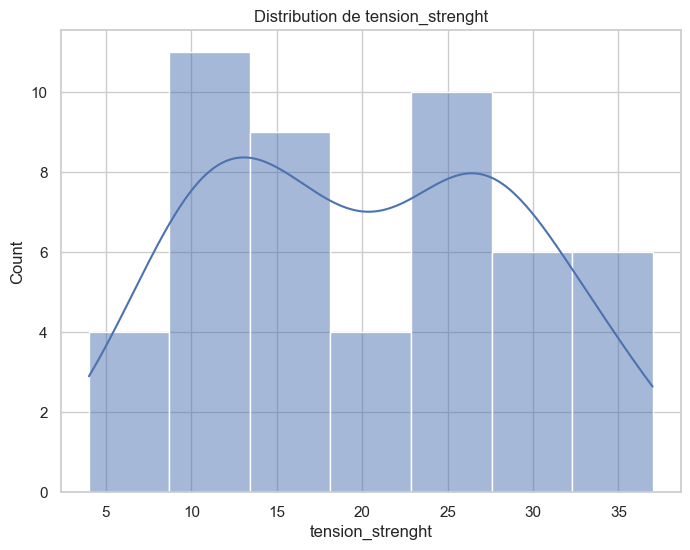

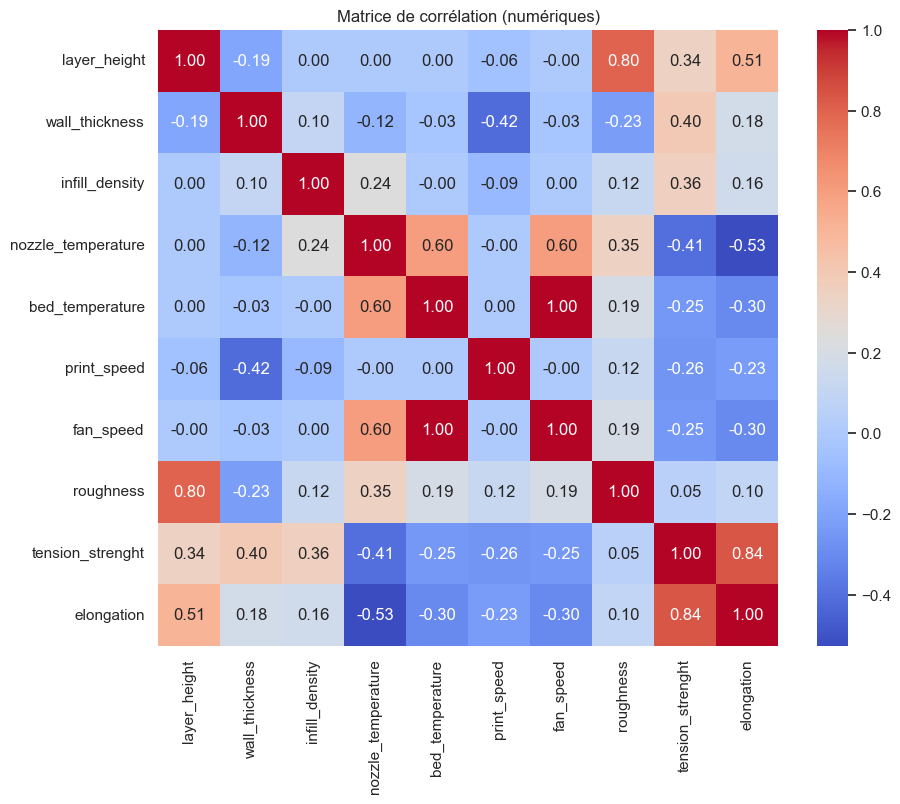

In [48]:
# Statistiques descriptives
display(df.describe(include='all').T)

# Colonnes catégorielles
cat_cols = df.select_dtypes(include=['object','category']).columns.tolist()
print("Colonnes catégorielles :", cat_cols)
for c in cat_cols:
    print(f"\nValeurs de '{c}':")
    print(df[c].value_counts())

# Distribution de la target
plt.figure()
sns.histplot(df['tension_strenght'], kde=True)
plt.title('Distribution de tension_strenght')
plt.show()

# Corrélation (numérique)
num_cols = df.select_dtypes(include=['int64','float64']).columns.tolist()
plt.figure(figsize=(10,8))
sns.heatmap(df[num_cols].corr(), annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Matrice de corrélation (numériques)')
plt.show()


**EDA note:** if certain numerical columns (e.g., `elongation`, `roughness`) are strongly correlated with `tension_strength`, a decision must be made as to whether to keep them (post-measurement analysis) or remove them (pre-production prediction).


In [49]:
# Afficher corrélation triée avec la target
corr_with_target = df[num_cols].corr()['tension_strenght'].sort_values(ascending=False)
print("Correlation with tension_strenght :")
print(corr_with_target) 

Correlation with tension_strenght :
tension_strenght      1.000000
elongation            0.838109
wall_thickness        0.399849
infill_density        0.358464
layer_height          0.338230
roughness             0.051617
bed_temperature      -0.252883
fan_speed            -0.252883
print_speed          -0.264590
nozzle_temperature   -0.405908
Name: tension_strenght, dtype: float64


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/seaborn/categorical.py:640: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/seaborn/categorical.py:640: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/seaborn/categorical.py:640: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/seaborn/categorical.py:640: FutureWarning: SeriesGroupBy.grouper is deprecated and will be remo

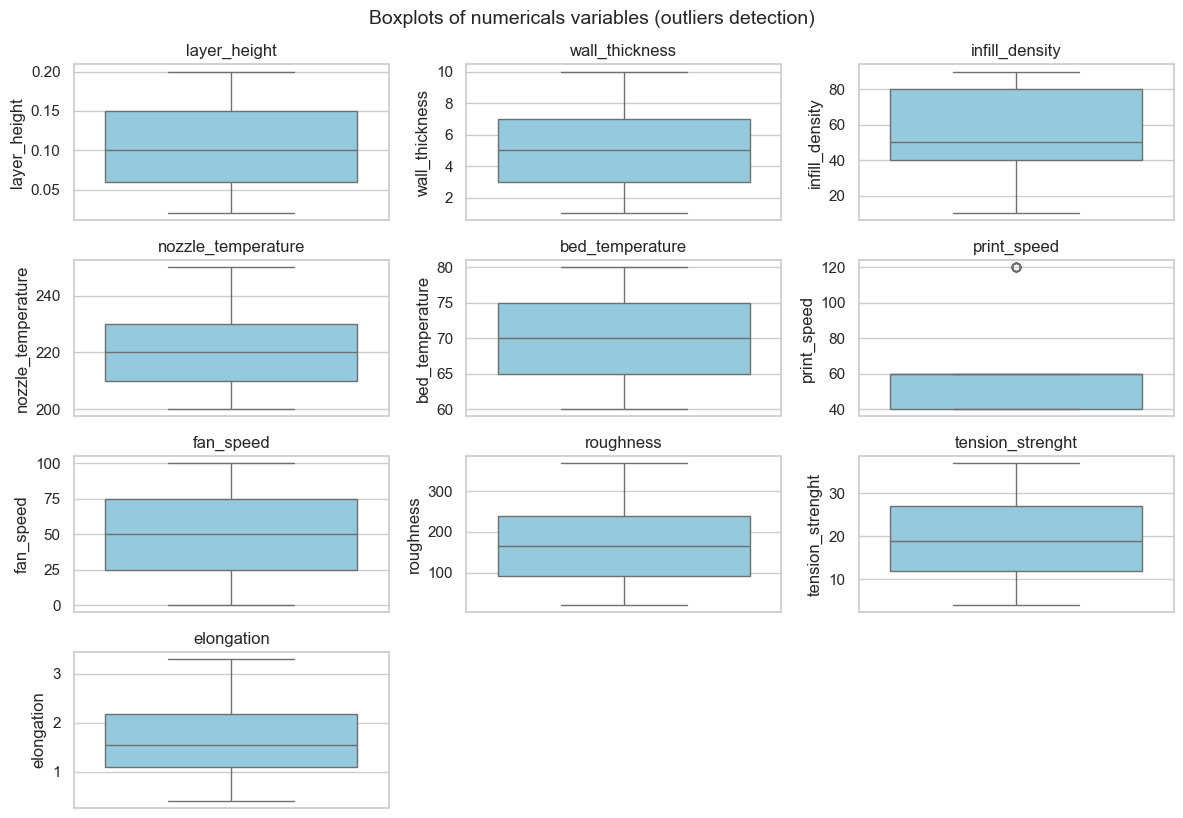

In [50]:
df_numeric = df.select_dtypes(include=['int64', 'float64'])
plt.figure(figsize=(12, 8))
for i, column in enumerate(df_numeric.columns, 1):
    plt.subplot((len(df_numeric.columns) + 2) // 3, 3, i)  # disposition 3 colonnes
    sns.boxplot(y=df_numeric[column], color='skyblue')
    plt.title(column)
    plt.tight_layout()

plt.suptitle("Boxplots of numericals variables (outliers detection)", fontsize=14, y=1.02)
plt.show()

We can see that there is some outliers concerning the feature **_print_speed_**, but there is 10 measured part in which print_speed is set on 120. So we can assume that this measurements are done on purpose and can explain output features. So we will keep them.

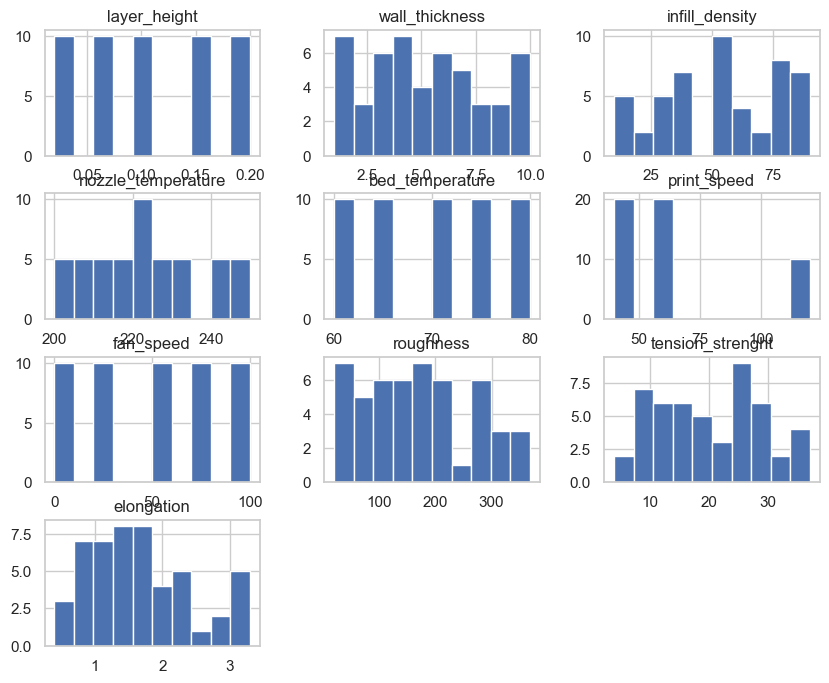

In [51]:
df.hist(figsize=(10, 8))
plt.show()

We can see that it is a quite balanced DataSet.

## 3) Preprocess and features preparation
- Imputation, scaling for numerical features.
- One-Hot Encoding pour categorials features.
- Split data into train and test (80%/20%).
- We will retain the option of implementing a “leak-free” variant at a later date.


In [52]:
TARGET = 'tension_strenght'
assert TARGET in df.columns, f"Target {TARGET} not find"

# Features / target      
X = df.drop(columns=[TARGET])
y = df[TARGET].astype(float)

# Identifier types
numeric_features = X.select_dtypes(include=['int64','float64']).columns.tolist()
categorical_features = X.select_dtypes(include=['object','category']).columns.tolist()

print("Numerical features :", numeric_features)
print("Categorials features :", categorical_features)


Numerical features : ['layer_height', 'wall_thickness', 'infill_density', 'nozzle_temperature', 'bed_temperature', 'print_speed', 'fan_speed', 'roughness', 'elongation']
Categorials features : ['infill_pattern', 'material']


In [53]:
# Pipelines for preprocessing
numeric_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False)
    )])

preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features)
])


## 4) Basis models & validation
- Linear Regression (interpretable baseline).
- Random Forest (non-linear baseline).
- 5-fold cross-validation on the training set.

In [54]:
# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Pipelines models
lr_pipeline = Pipeline([('preprocessor', preprocessor), ('regressor', LinearRegression())])
rf_pipeline = Pipeline([('preprocessor', preprocessor), ('regressor', RandomForestRegressor(n_estimators=100, random_state=42))])

# Cross-validation (R2)
cv = KFold(n_splits=5, shuffle=True, random_state=42)
lr_cv_scores = cross_val_score(lr_pipeline, X_train, y_train, cv=cv, scoring='r2')
rf_cv_scores = cross_val_score(rf_pipeline, X_train, y_train, cv=cv, scoring='r2')

print(f"LR CV mean R2: {lr_cv_scores.mean():.4f} (std {lr_cv_scores.std():.4f})")
print(f"RF CV mean R2: {rf_cv_scores.mean():.4f} (std {rf_cv_scores.std():.4f})")

# training
lr_pipeline.fit(X_train, y_train)
rf_pipeline.fit(X_train, y_train)

# prediction 
y_pred_lr = lr_pipeline.predict(X_test)
y_pred_rf = rf_pipeline.predict(X_test)

# Metrics
def regression_report(y_true, y_pred):
    return {
        'RMSE': mean_squared_error(y_true, y_pred),
        'MAE': mean_absolute_error(y_true, y_pred),
        'R2': r2_score(y_true, y_pred)
    }

results = {
    'LinearRegression': regression_report(y_test, y_pred_lr),
    'RandomForest': regression_report(y_test, y_pred_rf)
}

pprint(results)


LR CV mean R2: 0.5127 (std 0.1132)
RF CV mean R2: 0.6781 (std 0.1403)
{'LinearRegression': {'MAE': 3.755096141012378,
                      'R2': 0.7682617565282078,
                      'RMSE': 19.28293923928783},
 'RandomForest': {'MAE': 3.9240000000000004,
                  'R2': 0.7211561110443456,
                  'RMSE': 23.202599999999997}}


## 5) Visualisations & diagnostics
- Actual vs Predicted.
- Residuals
- Features repartition (RF).


best model : LinearRegression


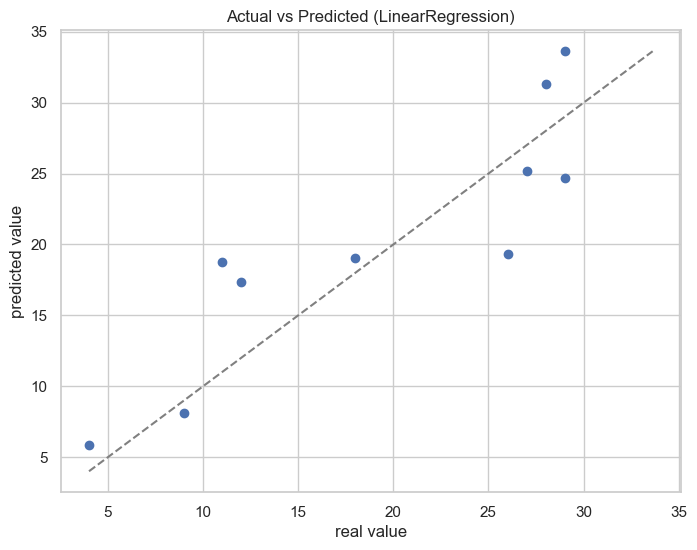

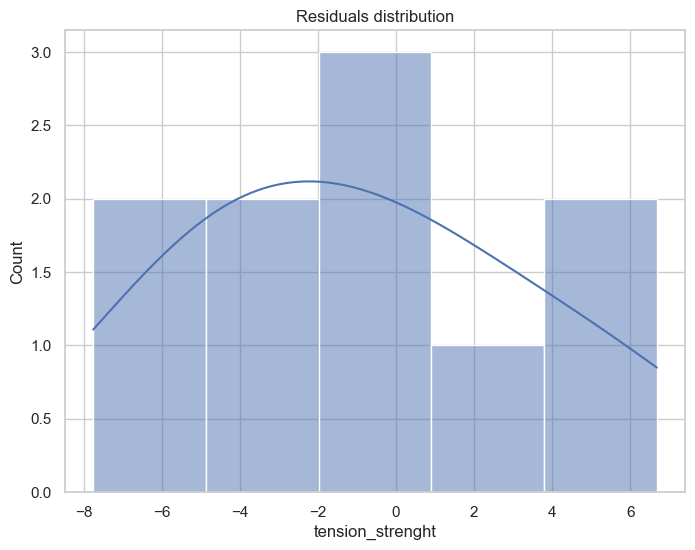

,feature,importance
8,elongation,0.726746
2,infill_density,0.108198
1,wall_thickness,0.066447
7,roughness,0.020593
3,nozzle_temperature,0.016544
4,bed_temperature,0.013264
0,layer_height,0.010272
6,fan_speed,0.009476
5,print_speed,0.009409
12,material_pla,0.006071


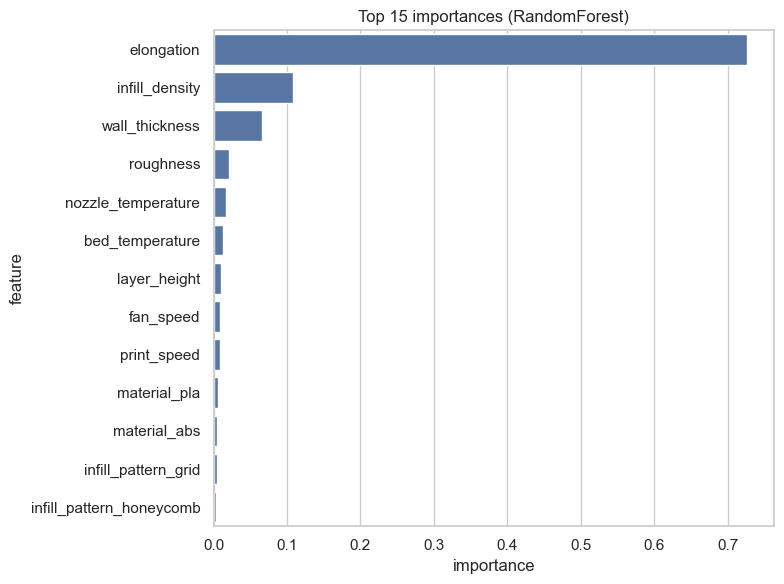

In [55]:
# choose the best model (R2) on test to plot Actual vs Predicted
best_name = 'LinearRegression' if results['LinearRegression']['R2'] >= results['RandomForest']['R2'] else 'RandomForest'
print("best model :", best_name)

y_best = y_pred_lr if best_name == 'LinearRegression' else y_pred_rf

# Scatter Actual vs Predicted
plt.figure()
plt.scatter(y_test, y_best)
minv, maxv = min(y_test.min(), y_best.min()), max(y_test.max(), y_best.max())
plt.plot([minv, maxv], [minv, maxv], '--', color='gray')
plt.xlabel('real value')
plt.ylabel('predicted value')
plt.title(f'Actual vs Predicted ({best_name})')
plt.show()

# Residuals
residuals = y_test - y_best
plt.figure()
sns.histplot(residuals, kde=True)
plt.title('Residuals distribution')
plt.show()

# Feature repartition (RandomForest)
preproc_fit = rf_pipeline.named_steps['preprocessor']
num_feats = numeric_features
if categorical_features:
    ohe = preproc_fit.named_transformers_['cat'].named_steps['onehot']
    cat_feats = list(ohe.get_feature_names_out(categorical_features))
else:
    cat_feats = []
feature_names = num_feats + cat_feats

rf_model = rf_pipeline.named_steps['regressor']
importances = rf_model.feature_importances_
feat_imp = pd.DataFrame({'feature': feature_names, 'importance': importances}).sort_values('importance', ascending=False)
display(feat_imp.head(20))

# Plot top importances
plt.figure(figsize=(8,6))
sns.barplot(x='importance', y='feature', data=feat_imp.head(15))
plt.title('Top 15 importances (RandomForest)')
plt.tight_layout()
plt.show()


## grid search for random forest model

In [56]:
from sklearn.model_selection import GridSearchCV

# parameters grid
param_grid = {
    'regressor__n_estimators': [100, 200, 300, 500],
    'regressor__max_depth': [None, 5, 10, 20, 30],
    'regressor__min_samples_split': [2, 5, 10],
    'regressor__min_samples_leaf': [1, 2, 4],
    'regressor__max_features': ['sqrt', 'log2', None],
    'regressor__bootstrap': [True, False]
}

# Grid Search
grid_search = GridSearchCV(
    estimator=rf_pipeline,
    param_grid=param_grid,
    scoring='r2',
    cv=3,               
    n_jobs=-1,
    verbose=2
)

# train
grid_search.fit(X_train, y_train)

print("best parameters :", grid_search.best_params_)
print("best score R2 (CV) :", grid_search.best_score_)

# optimized model
best_rf_pipeline = grid_search.best_estimator_

# Predictions test
y_pred_best_rf = best_rf_pipeline.predict(X_test)

print("Performance :")
print({
    'RMSE': mean_squared_error(y_test, y_pred_best_rf),
    'MAE': mean_absolute_error(y_test, y_pred_best_rf),
    'R2': r2_score(y_test, y_pred_best_rf)
})


Fitting 3 folds for each of 1080 candidates, totalling 3240 fits
[CV] END regressor__bootstrap=True, regressor__max_depth=None, regressor__max_features=sqrt, regressor__min_samples_leaf=1, regressor__min_samples_split=2, regressor__n_estimators=100; total time=   0.1s
[CV] END regressor__bootstrap=True, regressor__max_depth=None, regressor__max_features=sqrt, regressor__min_samples_leaf=1, regressor__min_samples_split=2, regressor__n_estimators=100; total time=   0.1s
[CV] END regressor__bootstrap=True, regressor__max_depth=None, regressor__max_features=sqrt, regressor__min_samples_leaf=1, regressor__min_samples_split=2, regressor__n_estimators=100; total time=   0.2s
[CV] END regressor__bootstrap=True, regressor__max_depth=None, regressor__max_features=sqrt, regressor__min_samples_leaf=1, regressor__min_samples_split=2, regressor__n_estimators=200; total time=   0.2s
[CV] END regressor__bootstrap=True, regressor__max_depth=None, regressor__max_features=sqrt, regressor__min_samples_lea

With only 50 individuals, there isn't much data, so it's very difficult to get good results with a machine learning model. That's why this cell takes *around a minut* to compile.
### Grid search results are above

## 6) Critical analysis (data leakage)
- If characteristics measured after production (e.g., elongation, roughness) are used as features, this may cause information leakage if the objective is to predict strength **before** manufacturing.
- Two scenarios:
- **Scenario A (post-measurement)**: these features are accepted -> goal: explain relationships between measured properties.
- **Scenario B (pre-production)**: these features are removed -> model usable before manufacturing.


In [57]:
# 'elongation' et 'roughness' correlation
for c in ['elongation','roughness']:
    if c in df.columns:
        corr = df[[c,TARGET]].corr().iloc[0,1]
        print(f"Correlation {c} vs {TARGET} : {corr:.4f}")


Correlation elongation vs tension_strenght : 0.8381
Correlation roughness vs tension_strenght : 0.0516


## 7) Variant: model **without** leakage (remove ‘elongation’ and ‘roughness’ if present)
- Repeat preprocessing + training without these columns.


In [58]:
leak_cols = [c for c in ['elongation','roughness'] if c in X.columns]
print("Columns sup for the variant without leak :", leak_cols)

X_noleak = X.drop(columns=leak_cols)
numeric_features_nl = X_noleak.select_dtypes(include=['int64','float64']).columns.tolist()
categorical_features_nl = X_noleak.select_dtypes(include=['object','category']).columns.tolist()

# new preprocess
preprocessor_nl = ColumnTransformer(transformers=[
    ('num', Pipeline([('imputer', SimpleImputer(strategy='median')),('scaler', StandardScaler())]), numeric_features_nl),
    ('cat', Pipeline([('imputer', SimpleImputer(strategy='most_frequent')), ('onehot', OneHotEncoder(handle_unknown='ignore',sparse_output=False))]), categorical_features_nl)
])

# Split
Xn_train, Xn_test, yn_train, yn_test = train_test_split(X_noleak, y, test_size=0.2, random_state=42)

# Pipelines
lr_nl = Pipeline([('preprocessor', preprocessor_nl), ('regressor', LinearRegression())])
rf_nl = Pipeline([('preprocessor', preprocessor_nl), ('regressor', RandomForestRegressor(n_estimators=100, random_state=42))])

# CV
lr_nl_cv = cross_val_score(lr_nl, Xn_train, yn_train, cv=cv, scoring='r2')
rf_nl_cv = cross_val_score(rf_nl, Xn_train, yn_train, cv=cv, scoring='r2')

print(f"LR (no leak) CV mean R2: {lr_nl_cv.mean():.4f}")
print(f"RF (no leak) CV mean R2: {rf_nl_cv.mean():.4f}")

# Fit et predict
lr_nl.fit(Xn_train, yn_train)
rf_nl.fit(Xn_train, yn_train)
yn_pred_lr = lr_nl.predict(Xn_test)
yn_pred_rf = rf_nl.predict(Xn_test)

results_nl = {
    'LR_no_leak': regression_report(yn_test, yn_pred_lr),
    'RF_no_leak': regression_report(yn_test, yn_pred_rf)
}
print(results_nl)


Columns sup for the variant without leak : ['elongation', 'roughness']
LR (no leak) CV mean R2: 0.2879
RF (no leak) CV mean R2: 0.5014
{'LR_no_leak': {'RMSE': 46.9516528574737, 'MAE': 6.162390916940969, 'R2': 0.4357450684115648}, 'RF_no_leak': {'RMSE': 35.51521, 'MAE': 5.147, 'R2': 0.5731857949765653}}


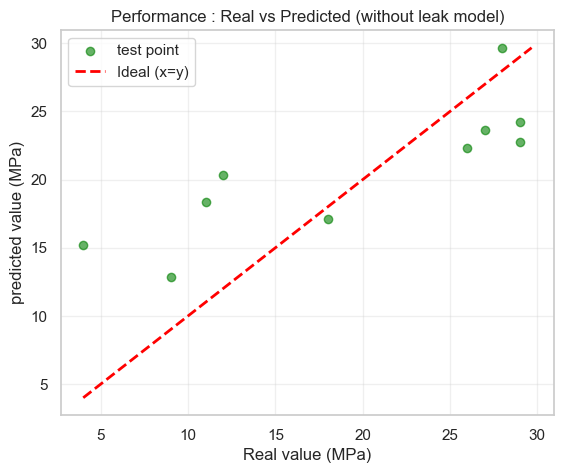


Top 5 most important features (no leaks) :
              Feature  Importance
2      infill_density    0.253103
3  nozzle_temperature    0.224782
1      wall_thickness    0.196299
0        layer_height    0.186817
4     bed_temperature    0.035342


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_su

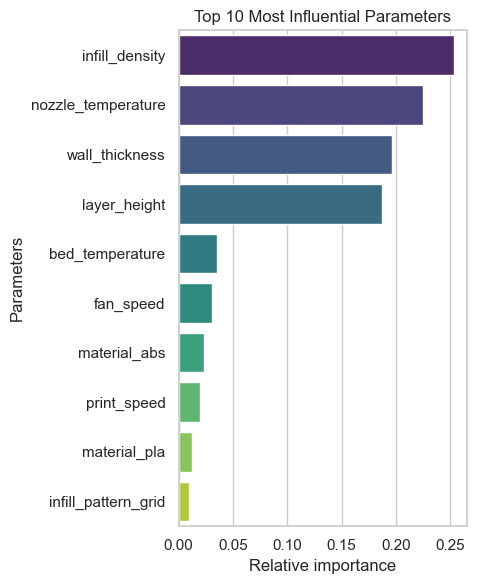

In [59]:
# 1. Comparaison Actual vs Predicted for Random Forest (globally better)
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.scatter(yn_test, yn_pred_rf, color='green', alpha=0.6, label='test point')
# perfect reference lign
min_val = min(yn_test.min(), yn_pred_rf.min())
max_val = max(yn_test.max(), yn_pred_rf.max())
plt.plot([min_val, max_val], [min_val, max_val], '--', color='red', linewidth=2, label='Ideal (x=y)')
plt.xlabel('Real value (MPa)')
plt.ylabel('predicted value (MPa)')
plt.title('Performance : Real vs Predicted (without leak model)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# 2. Importance of features (Random Forest without leak)
# Retrieving feature names after encoding
# Access the ‘cat’ transformer in the preprocessor, then the ‘onehot’ step
ohe = rf_nl.named_steps['preprocessor'].named_transformers_['cat'].named_steps['onehot']
cat_feature_names = list(ohe.get_feature_names_out(categorical_features_nl))
all_feature_names = numeric_features_nl + cat_feature_names

#  importances
importances = rf_nl.named_steps['regressor'].feature_importances_
feat_imp_df = pd.DataFrame({'Feature': all_feature_names, 'Importance': importances})
feat_imp_df = feat_imp_df.sort_values(by='Importance', ascending=False)

plt.subplot(1, 2, 2)
sns.barplot(
    x='Importance', 
    y='Feature', 
    hue='Feature',  # <-- color for features
    legend=False,   # <-- We hide the caption because it would be redundant.
    data=feat_imp_df.head(10), 
    palette='viridis'
)
plt.title('Top 10 Most Influential Parameters')
plt.xlabel('Relative importance')
plt.ylabel('Parameters')

plt.tight_layout()
plt.savefig('results_without_leak.png')
print("\nTop 5 most important features (no leaks) :")
print(feat_imp_df.head(5))



## 8) Saving models and results
- Save trained pipelines for reuse.
- Export feature importance.


In [60]:
import os
os.makedirs('models', exist_ok=True)

joblib.dump(lr_pipeline, 'models/lr_pipeline_full.joblib')
joblib.dump(rf_pipeline, 'models/rf_pipeline_full.joblib')
joblib.dump(lr_nl, 'models/lr_pipeline_no_leak.joblib')
joblib.dump(rf_nl, 'models/rf_pipeline_no_leak.joblib')
print("Models saved in folder 'models/'.")


Models saved in folder 'models/'.


Evaluation results:
               Model       MAE      RMSE        R2
0  Gradient Boosting  4.874210  6.066230  0.557756
1   SVR (RBF Kernel)  6.348748  7.129164  0.389196


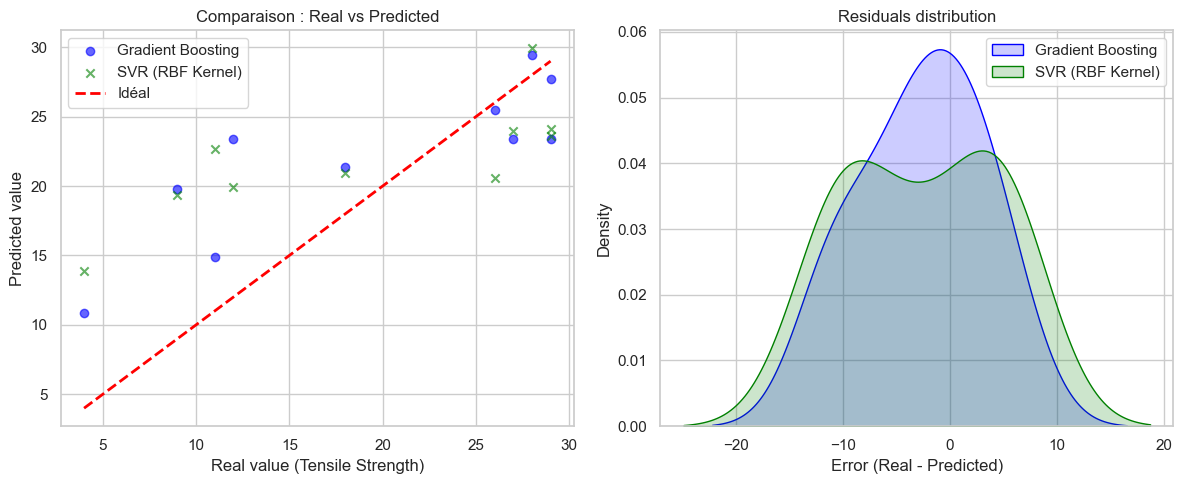

In [61]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# import XGBoost. Otherwise we will use GradientBoostingRegressor as fallback proche.
try:
    from xgboost import XGBRegressor
    xgb_available = True
except ImportError:
    from sklearn.ensemble import GradientBoostingRegressor
    xgb_available = False

# 1. load data
df = pd.read_csv('data.csv')

# 2.  features and target selection 
features = ['infill_density', 'wall_thickness', 'nozzle_temperature', 'bed_temperature']
target = 'tension_strenght'

X = df[features]
y = df[target]

# 3. split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 4. Preprocessing (Standardisation is very important for the SVM)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 5. Initialisation and training of the  models

# Model A: XGBoost (or Gradient Boosting if XGBoost is missing)
if xgb_available:
    model_xgb = XGBRegressor(n_estimators=100, random_state=42)
    model_name_1 = "XGBoost"
else:
    model_xgb = GradientBoostingRegressor(n_estimators=100, random_state=42)
    model_name_1 = "Gradient Boosting"

model_xgb.fit(X_train_scaled, y_train)

# Model B: SVM (SVR with kernel RBF)
model_svr = SVR(kernel='rbf', C=10.0, epsilon=0.1) # C and epsilon are standarts hyperparameters to adjust, we take classic default values
model_name_2 = "SVR (RBF Kernel)"
model_svr.fit(X_train_scaled, y_train)

# 6. Predictions
y_pred_xgb = model_xgb.predict(X_test_scaled)
y_pred_svr = model_svr.predict(X_test_scaled)

# 7. evaluation
def evaluate(y_true, y_pred, model_name):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    return {'Model': model_name, 'MAE': mae, 'RMSE': rmse, 'R2': r2}

metrics_xgb = evaluate(y_test, y_pred_xgb, model_name_1)
metrics_svr = evaluate(y_test, y_pred_svr, model_name_2)

results_df = pd.DataFrame([metrics_xgb, metrics_svr])

print("Evaluation results:")
print(results_df)

# 8. Visualisation
plt.figure(figsize=(12, 5))

# Scatter plot: Actual vs Predicted for both models
plt.subplot(1, 2, 1)
plt.scatter(y_test, y_pred_xgb, color='blue', alpha=0.6, label=model_name_1, marker='o')
plt.scatter(y_test, y_pred_svr, color='green', alpha=0.6, label=model_name_2, marker='x')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--', color='red', linewidth=2, label='Idéal')
plt.xlabel('Real value (Tensile Strength)')
plt.ylabel('Predicted value')
plt.title('Comparaison : Real vs Predicted')
plt.legend()

# residuals plot
plt.subplot(1, 2, 2)
sns.kdeplot(y_test - y_pred_xgb, color='blue', label=model_name_1, fill=True, alpha=0.2)
sns.kdeplot(y_test - y_pred_svr, color='green', label=model_name_2, fill=True, alpha=0.2)
plt.xlabel('Error (Real - Predicted)')
plt.title('Residuals distribution')
plt.legend()

plt.tight_layout()
plt.savefig('new_models_evaluation.png')
plt.show()